<a href="https://colab.research.google.com/github/NicoPolazzi/kube-performance-predictor/blob/gnn/kpp/gnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import torch

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}.html
!pip install torch-geometric

2.9.0+cu126
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp312-cp312-linux_x86_64.whl size=3857040 sha256=4dd5dd49dbf03e3b4d9739c676712cb75336fe7a3e3a7b9c8627aa6136af52d4
  Stored in directory: /root/.cache/pip/wheels/84/20/50/44800723f57cd798630e77b3ec83bc80bd26a1e3dc3a672ef5
Successfully built torch-scatter
Looking in links: https://pytorch-geometric.com/whl/torch-{TORCH}.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp312-cp312-linux_x86_64.whl size=3039798 sha256=2baae9bb7bd6fbe534edf3370515924912cc4d1a21d537fef7cc94e7414bdae3
  Stored in directory: /root/.cache/pip/wheels/71/fa/21/bd1d78ce1629aec4ecc924a63b82f6949dda484b6321eac6f2


In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset
from torch_geometric.nn import GATConv

### Dataset Definition

In [15]:
NODE_ORDER = [
    'checkoutservice',
    'emailservice',
    'currencyservice',
    'paymentservice',
    'frontend',
    'cartservice',
    'adservice',
    'shippingservice',
    'recommendationservice',
    'productcatalogservice'
]

# Adjacency Matrix (Source -> Destination)
# 1 = Connection, 0 = No connection
ADJ_MATRIX = [
    # fr, ad, rec,cat,chk,crt,shp,cur,pay,eml
    [0,  1,  1,  1,  1,  1,  1,  1,  0,  0], # frontend
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # ad
    [0,  0,  0,  1,  0,  0,  0,  0,  0,  0], # recommendation
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # productcatalog
    [0,  0,  0,  1,  0,  1,  1,  1,  1,  1], # checkout
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # cart
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # shipping
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # currency
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # payment
    [0,  0,  0,  0,  0,  0,  0,  0,  0,  0], # email
]

def get_static_edge_index():
    """Converts the matrix to the format required by PyTorch Geometric, because we need an edge list"""
    rows, cols = np.where(np.array(ADJ_MATRIX) == 1)
    return torch.tensor([rows, cols], dtype=torch.long)

class MicroserviceDataset(Dataset):
    def __init__(self, csv_file, window_size=5):
        self.window_size = window_size
        self.data, self.num_timestamps = self._load_data(csv_file)

    def _load_data(self, csv_file):
        try:
            df = pd.read_csv(csv_file)
        except FileNotFoundError:
            raise FileNotFoundError(f"Could not find {csv_file}. Did you upload it?")

        df = df[df['Service'].isin(NODE_ORDER)]
        df['Service'] = pd.Categorical(df['Service'], categories=NODE_ORDER, ordered=True)
        df = df.sort_values(by=['Timestamp', 'Service'])

        feature_cols = ['User Count', 'Response Time (s)', 'Throughput (req/s)', 'CPU Usage']
        df[feature_cols] = df[feature_cols].fillna(0)
        features = df[feature_cols].values

        num_nodes = len(NODE_ORDER)
        num_timestamps = df['Timestamp'].nunique()

        # Validation
        expected_rows = num_timestamps * num_nodes
        if len(features) != expected_rows:
            print(f"Warning: Data misalignment! Found {len(features)} rows, expected {expected_rows}.")


        # The tesor shape dimension will be: (Timestamps, Nodes, Features)
        data_tensor = torch.tensor(features, dtype=torch.float32).view(num_timestamps, num_nodes, -1)
        return data_tensor, num_timestamps

    def __len__(self):
        # We need `window_size` steps for input + 1 step for target
        return self.data.shape[0] - self.window_size

    def __getitem__(self, idx):
        # Input: Sequence of snapshots [t, ..., t+window-1]
        x_seq = self.data[idx : idx + self.window_size]
        # Target: The NEXT snapshot [t+window]
        y_next = self.data[idx + self.window_size]
        return x_seq, y_next

### Model definition

In [13]:
class GATLSTM(nn.Module):
    def __init__(self, num_nodes, in_channels, hidden_channels, out_channels, edge_index):
        super(GATLSTM, self).__init__()
        self.num_nodes = num_nodes
        self.edge_index = edge_index

        # Spatial Layer: Graph Attention Network
        self.gat = GATConv(in_channels, hidden_channels, heads=1)

        # Temporal Layer: LSTM
        # Input to LSTM is the flattened output of the GAT for all nodes
        self.lstm = nn.LSTM(input_size=num_nodes * hidden_channels,
                            hidden_size=64,
                            batch_first=True)

        # Prediction Head: Maps back to original feature space
        self.fc = nn.Linear(64, num_nodes * out_channels)

    def forward(self, x_seq):
        batch_size, window_size, nodes, feats = x_seq.size()

        spatial_embeddings = []
        for t in range(window_size):
            xt = x_seq[:, t, :, :] # Shape: (Batch, Nodes, Features)
            batch_emb = []
            for b in range(batch_size):
                # GATConv expects (Nodes, Features)
                out = self.gat(xt[b], self.edge_index)
                batch_emb.append(out.flatten())

            # Stack batch results: (Batch, Nodes * Hidden)
            spatial_embeddings.append(torch.stack(batch_emb))

        # Stack time sequence: (Batch, Window_Size, Nodes * Hidden)
        lstm_input = torch.stack(spatial_embeddings, dim=1)
        lstm_out, _ = self.lstm(lstm_input)

        # Take the output of the last time step
        last_hidden = lstm_out[:, -1, :]
        out = self.fc(last_hidden)
        # Reshape to (Batch, Nodes, Features)
        return out.view(batch_size, nodes, -1)

### Configuration

In [22]:
csv_path = "/content/drive/MyDrive/kube-performance-predictor/performance_results.csv"

# Hyperparameters
WINDOW_SIZE = 5
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

dataset = MicroserviceDataset(csv_path, window_size=WINDOW_SIZE)
total_len = len(dataset)
train_size = int(0.7 * total_len)
val_size = int(0.15 * total_len)
test_size = int(0.15 * total_len)

# Create subsets using ranges to maintain temporal order
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, train_size + val_size))
test_dataset = Subset(dataset, range(train_size + val_size, total_len))

# Loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"Data Split: Train={len(train_dataset)}, Val={len(val_dataset)}, Test={len(test_dataset)}")

Using device: cuda
Data Split: Train=488, Val=104, Test=106


### Training

Data Split: Train=488, Val=104, Test=106
Starting training...
Epoch 5/50 | Train Loss: 793.891227 | Val Loss: 2788.087393 -> Saved Best Model
Epoch 10/50 | Train Loss: 513.944930 | Val Loss: 2097.289419 -> Saved Best Model
Epoch 15/50 | Train Loss: 338.817361 | Val Loss: 1595.576299 -> Saved Best Model
Epoch 20/50 | Train Loss: 229.217108 | Val Loss: 1231.715614 -> Saved Best Model
Epoch 25/50 | Train Loss: 168.919090 | Val Loss: 1012.669889 -> Saved Best Model
Epoch 30/50 | Train Loss: 131.673486 | Val Loss: 870.083226 -> Saved Best Model
Epoch 35/50 | Train Loss: 98.530469 | Val Loss: 728.544943 -> Saved Best Model
Epoch 40/50 | Train Loss: 79.295978 | Val Loss: 648.045673 -> Saved Best Model
Epoch 45/50 | Train Loss: 57.988106 | Val Loss: 547.202498 -> Saved Best Model
Epoch 50/50 | Train Loss: 40.655862 | Val Loss: 455.382766 -> Saved Best Model
Training finished.


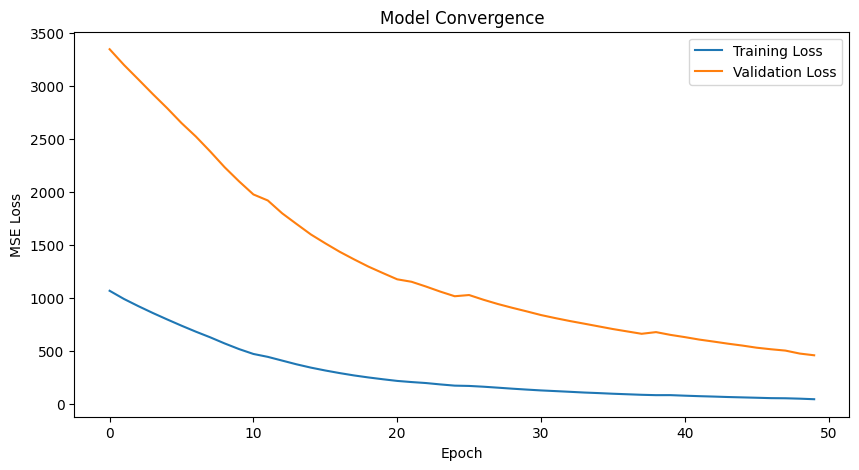

In [19]:
edge_index = get_static_edge_index().to(device)
features_count = 4

model = GATLSTM(
    num_nodes=len(NODE_ORDER),
    in_channels=features_count,        # [User, Resp, Thru, CPU]
    hidden_channels=16,   # Dimension of graph embedding
    out_channels=features_count,       # Output features to predict
    edge_index=edge_index
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

print("Starting training...")
loss_history = []

best_val_loss = float('inf')
train_history = []
val_history = []

for epoch in range(EPOCHS):
    # A. Training Phase
    model.train()
    total_train_loss = 0
    for x_seq, y_true in train_loader:
        x_seq, y_true = x_seq.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_seq)
        loss = criterion(y_pred, y_true)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_history.append(avg_train_loss)

    # B. Validation Phase (No Gradient)
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for x_val, y_val in val_loader:
            x_val, y_val = x_val.to(device), y_val.to(device)
            val_pred = model(x_val)
            v_loss = criterion(val_pred, y_val)
            total_val_loss += v_loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_history.append(avg_val_loss)

    # C. Checkpointing (Save Best Model)
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), 'best_model_gat_lstm.pth')
        saved_msg = "-> Saved Best Model"
    else:
        saved_msg = ""

    if (epoch+1) % 5 == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f} {saved_msg}")

print("Training finished.")

plt.figure(figsize=(10, 5))
plt.plot(train_history, label='Training Loss')
plt.plot(val_history, label='Validation Loss')
plt.title("Model Convergence")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.show()


# Test Phase
print("\nEvaluating on Test Set...")

# Load the best state
model.load_state_dict(torch.load('best_model_gat_lstm.pth'))
model.eval() # Set to evaluation mode (disables dropout, etc.)

total_test_loss = 0

with torch.no_grad():
    for x_test, y_test in test_loader:
        x_test, y_test = x_test.to(device), y_test.to(device)

        # Predict
        y_pred = model(x_test)

        loss = criterion(y_pred, y_test)
        total_test_loss += loss.item()

print(f"Final Test MSE Loss: {total_test_loss / len(test_loader):.6f}")